In [1]:
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras.datasets import cifar10

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print ('check shapes: ', x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# train_im, test_im = x_train/255.0 , x_test/255.0

train_lab_categorical = tf.keras.utils.to_categorical(y_train, num_classes = 10, dtype = 'uint8')

test_lab_categorical = tf.keras.utils.to_categorical(y_test, num_classes = 10, dtype = 'uint8')

from sklearn.model_selection import train_test_split 
train_im, valid_im, train_lab, valid_lab = train_test_split(x_train, train_lab_categorical, test_size = 0.20, 
                                                            stratify = train_lab_categorical, 
                                                            random_state = 40, shuffle = True) # stratify is unncessary 

print ("train data shape after the split: ", train_im.shape)
print ('new validation data shape: ', valid_im.shape)
print ("validation labels shape: ", valid_lab.shape)

class_types = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'] # from cifar-10 website

print ('train im and label types: ', type(train_im), type(train_lab))

training_data = tf.data.Dataset.from_tensor_slices((train_im, train_lab))
validation_data = tf.data.Dataset.from_tensor_slices((valid_im, valid_lab))
test_data = tf.data.Dataset.from_tensor_slices((x_test, test_lab_categorical))

print ('check types; ', type(training_data), type(validation_data))


autotune = tf.data.AUTOTUNE 

train_data_batches = training_data.shuffle(buffer_size = 40000).batch(128).prefetch(buffer_size = autotune)
valid_data_batches = validation_data.shuffle(buffer_size = 10000).batch(32).prefetch(buffer_size = autotune)
test_data_batches = test_data.shuffle(buffer_size = 10000).batch(32).prefetch(buffer_size = autotune)

170498071/170498071 [==============================] - 6s 0us/step
check shapes:  (50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
train data shape after the split:  (40000, 32, 32, 3)
new validation data shape:  (10000, 32, 32, 3)
validation labels shape:  (10000, 10)
train im and label types:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
check types;  <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'> <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


In [3]:
class generate_patch(layers.Layer):
  def __init__(self, patch_size):
    super(generate_patch, self).__init__()
    self.patch_size = patch_size
    
  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(images = images, 
                                       sizes = [1, self.patch_size, self.patch_size, 1], 
                                       strides = [1, self.patch_size, self.patch_size, 1], rates = [1, 1, 1, 1], padding = "VALID")
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims]) # here shape is (batch_size, num_patches, patch_h*patch_w*c) 
    return patches

check shapes:  (1, 32, 32, 3)
patch per image and patches shape:  64 
 (1, 64, 48)


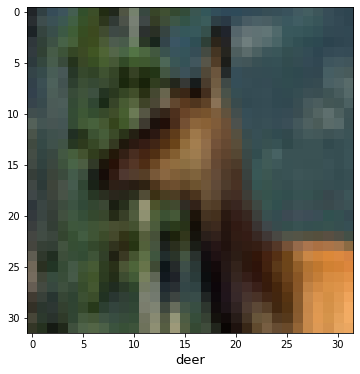

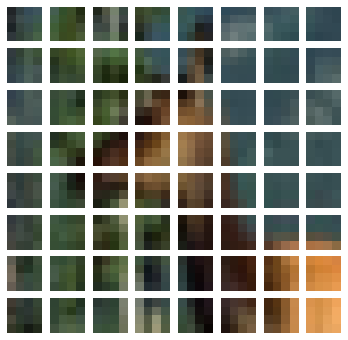

In [4]:
from itertools import islice, count

train_iter_7im, train_iter_7label = next(islice(training_data, 7, None)) # access the 7th element from the iterator



train_iter_7im = tf.expand_dims(train_iter_7im, 0)
train_iter_7label = train_iter_7label.numpy()

print('check shapes: ', train_iter_7im.shape) 

patch_size = 4
######################
# num patches (W * H) / P^2 where W, H are from original image, P is patch dim. 
# Original image (H * W * C), patch N * P * P * C, N num patches
######################
generate_patch_layer = generate_patch(patch_size = patch_size)
patches = generate_patch_layer(train_iter_7im)

print ('patch per image and patches shape: ', patches.shape[1], '\n', patches.shape)



def render_image_and_patches(image, patches):
    plt.figure(figsize = (6, 6))
    plt.imshow(tf.cast(image[0], tf.uint8))
    plt.xlabel(class_types [np.argmax(train_iter_7label)], fontsize = 13)
    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize = (6, 6))
    #plt.suptitle(f"Image Patches", size = 13)
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i + 1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        ax.imshow(patch_img.numpy().astype("uint8"))
        ax.axis('off')    

        


render_image_and_patches(train_iter_7im, patches)

In [5]:
### Positonal Encoding Layer

class PatchEncode_Embed(layers.Layer):
  '''
  2 steps happen here
  1. flatten the patches 
  2. Map to dim D; patch embeddings  
  '''
  def __init__(self, num_patches, projection_dim):
    super(PatchEncode_Embed, self).__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units = projection_dim) # activation = linear
    self.position_embedding = layers.Embedding(
        input_dim = num_patches, output_dim = projection_dim)
    
  def call(self, patch):
    positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded

In [6]:
patch_encoder = PatchEncode_Embed(64, 64)(patches)
print (tf.shape(patch_encoder))

tf.Tensor([ 1 64 64], shape=(3,), dtype=int32)


In [7]:
class generate_patch_conv(layers.Layer):
  '''
  this is an example to generate conv patches comparable with the image patches
  generated using tf extract image patches. This wasn't the original implementation, specially 
  the number of filters in the conv layer has nothing to do with patch size. It must be same as
  hidden dim (query/key dim) in relation to multi-head attention layer.       
  '''
  def __init__(self, patch_size):
    super(generate_patch_conv, self).__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = layers.Conv2D(self.patch_size * self.patch_size * 3, self.patch_size, self.patch_size, padding = 'valid')(images)

    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches  

class generate_patch_conv_orgPaper(layers.Layer):
  '''
  original implementation, 
  hidden size = query / key dim in multi head attention layer later. 
  '''
  def __init__(self, patch_size, hidden_size):
    super(generate_patch_conv_orgPaper, self).__init__()
    self.patch_size = patch_size
    self.hidden_size = hidden_size

  def call(self, images):
    patches = layers.Conv2D(self.hidden_size, self.patch_size, self.patch_size, padding = 'valid', name = 'Embedding')(images) 
    # kernels and strides = patch size
    # the weights of the convolutional layer will be learned. 
    rows_axis, cols_axis = (1, 2) # channels last images
    #if channels_last:
      #rows_axis, cols_axis = (2, 3) # for channels last
      # x = tf.transpose(patches, perm = [0, 2, 3, 1]) # do this for channels_first
    seq_len = (images.shape[rows_axis] // patch_size) * (images.shape[cols_axis] // patch_size)
    x = tf.reshape(patches, [-1, seq_len, self.hidden_size])
    return x

def generate_patch_conv_orgPaper_f(patch_size, hidden_size, inputs):
  patches = layers.Conv2D(filters = hidden_size, kernel_size = patch_size, strides = patch_size, padding = 'valid')(inputs)
  row_axis, col_axis = (1, 2) # channels last images
  seq_len = (inputs.shape[row_axis] // patch_size) * (inputs.shape[col_axis] // patch_size)
  x = tf.reshape(patches, [-1, seq_len, hidden_size])
  return x




train_iter_7im = tf.cast(train_iter_7im, dtype = tf.float16)
generate_patch_conv_layer = generate_patch_conv(patch_size = patch_size)
patches_conv = generate_patch_conv_layer(train_iter_7im)


print ('patch per image and patches shape: ', patches_conv.shape[1], '\n', patches_conv.shape)    

generate_patch_conv_orgPaper_layer = generate_patch_conv_orgPaper(patch_size = patch_size, hidden_size = 64)
patches_conv_org = generate_patch_conv_orgPaper_layer(train_iter_7im)

hidden_size = 64
patches_conv_org_f = generate_patch_conv_orgPaper_f(patch_size, hidden_size, train_iter_7im)

print ('patch per image and patches shape: ', patches_conv_org.shape[1], '\n', patches_conv_org.shape)
print ('patch per image and patches shape: ', patches_conv_org_f.shape[1], '\n', patches_conv_org_f.shape)

patch per image and patches shape:  64 
 (1, 64, 48)
patch per image and patches shape:  64 
 (1, 64, 64)
patch per image and patches shape:  64 
 (1, 64, 64)


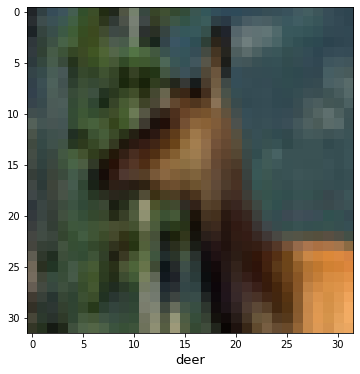

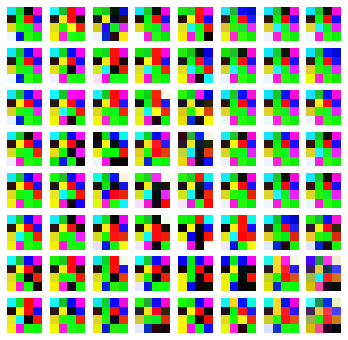

In [8]:
def render_image_and_patches(image, patches):
    plt.figure(figsize = (6, 6))
    plt.imshow(tf.cast(image[0], tf.uint8))
    plt.xlabel(class_types [np.argmax(train_iter_7label)], fontsize = 13)
    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize = (6, 6))
    #plt.suptitle(f"Image Patches", size=13)
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i + 1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        ax.imshow(patch_img.numpy().astype("uint8"))
        ax.axis('off')

render_image_and_patches(train_iter_7im, patches_conv)

In [9]:
### Positonal Encoding Layer

class AddPositionEmbs(layers.Layer):
  """Adds (optionally learned) positional embeddings to the inputs."""

  def __init__(self, posemb_init = None, **kwargs):
    super().__init__(**kwargs)
    self.posemb_init = posemb_init
    #posemb_init = tf.keras.initializers.RandomNormal(stddev = 0.02), name = 'posembed_input') # used in original code

  def build(self, inputs_shape):
    pos_emb_shape = (1, inputs_shape[1], inputs_shape[2])
    self.pos_embedding = self.add_weight('pos_embedding', pos_emb_shape, initializer = self.posemb_init)

  def call(self, inputs, inputs_positions = None):
    # inputs.shape is (batch_size, seq_len, emb_dim).
    pos_embedding = tf.cast(self.pos_embedding, inputs.dtype)

    return inputs + pos_embedding


pos_embed_layer = AddPositionEmbs(posemb_init = tf.keras.initializers.RandomNormal(stddev = 0.02))
embedded_inp = pos_embed_layer(patches_conv_org)

print ('embedded input shape: ', embedded_inp.shape)

embedded input shape:  (1, 64, 64)


In [10]:
# class mlp_block(layers.Layer):
#   def __init__(self, mlp_dim):
#     super(mlp_block, self).__init__()
#     self.mlp_dim = mlp_dim
#   def call(self, inputs):
#     x = layers.Dense(units=self.mlp_dim, activation=tf.nn.gelu)(inputs)
#     x = layers.Dropout(rate=0.1)(x) # dropout rate is from original paper,
#     x = layers.Dense(units=inputs.shape[-1], activation=tf.nn.gelu)(x)
#     x = layers.Dropout(rate=0.1)(x)
#     return x


def mlp_block_f(mlp_dim, inputs):
  x = layers.Dense(units = mlp_dim, activation = tf.nn.gelu)(inputs)
  x = layers.Dropout(rate = 0.1)(x) # dropout rate is from original paper,
  x = layers.Dense(units = inputs.shape[-1], activation = tf.nn.gelu)(x)
  x = layers.Dropout(rate = 0.1)(x)
  return x

# class Encoder1Dblock(layers.Layer):
#   def __init__(self, num_heads, mlp_dim):
#     super(Encoder1Dblock, self).__init__()
#     self.num_heads = num_heads # number of heads in multi-head block
#     self.mlp_dim = mlp_dim
#   def call(self, inputs):
#     x = layers.LayerNormalization(dtype=self.dtype)(inputs)
#     x = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=inputs.shape[-1], dropout=0.1)(x, x) # self attention multi-head, dropout_rate is from original implementation
#     x = layers.Add()([x, inputs]) # 1st residual part 
    
    # #### mlp block 
    # y = layers.LayerNormalization(dtype=self.dtype)(x)
    # y = mlp_block(mlp_dim=self.mlp_dim)(y)
    # y_1 = layers.Add()([y, x]) #2nd residual part 
    # return y_1


def Encoder1Dblock_f(num_heads, mlp_dim, inputs):
  x = layers.LayerNormalization(dtype = inputs.dtype)(inputs)
  x = layers.MultiHeadAttention(num_heads = num_heads, key_dim = inputs.shape[-1], dropout = 0.1)(x, x) # self attention multi-head, dropout_rate is from original implementation
  x = layers.Add()([x, inputs]) # 1st residual part 
  
  y = layers.LayerNormalization(dtype = x.dtype)(x)
  y = mlp_block_f(mlp_dim, y)
  y_1 = layers.Add()([y, x]) #2nd residual part 
  return y_1


#########################################
# test with the embeddings as input
#########################################
# Encoder1Dblock_layer = Encoder1Dblock(num_heads=4, mlp_dim=32)
# Encoder1Dblock_layer_out = Encoder1Dblock_layer(embedded_inp)
Encoder1Dblock_layer_out_f = Encoder1Dblock_f(4, 32, embedded_inp)

# print ('output shape of Encoder block when inputs are the embeddings: ', Encoder1Dblock_layer_out.shape)
print ('output shape of Encoder block when inputs are the embeddings: ', Encoder1Dblock_layer_out_f.shape)

output shape of Encoder block when inputs are the embeddings:  (1, 64, 64)


In [11]:
### augment train but not test 

rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(height_factor = (0.2, 0.3), width_factor = (0.2, 0.3)),
  layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode = 'reflect', interpolation = 'bilinear',)
])


train_ds = (training_data.shuffle(40000).batch(128).map(lambda x, y: (data_augmentation(x), y), num_parallel_calls = autotune).prefetch(autotune))
valid_ds = (validation_data.shuffle(10000).batch(32).prefetch(autotune))

In [12]:
# class Encoder(layers.Layer):
#   def __init__(self, num_layers, mlp_dim, num_heads):
#     super(Encoder, self).__init__()
#     self.num_layers = num_layers # number of times encoder repeats
#     self.mlp_dim = mlp_dim
#     self.num_heads = num_heads

#   def call(self, inputs):
#     x = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input')(inputs)
#     x = layers.Dropout(rate=0.2)(x)
#     for _ in range(self.num_layers):
#       x = Encoder1Dblock(mlp_dim=self.mlp_dim, num_heads=self.num_heads)(x)

#     encoded = layers.LayerNormalization(name='encoder_norm')(x)
#     return encoded


def Encoder_f(num_layers, mlp_dim, num_heads, inputs):
  x = AddPositionEmbs(posemb_init = tf.keras.initializers.RandomNormal(stddev = 0.02), name = 'posembed_input')(inputs)
  x = layers.Dropout(rate = 0.2)(x)
  for _ in range(num_layers):
    x = Encoder1Dblock_f(num_heads, mlp_dim, x)

  encoded = layers.LayerNormalization(name = 'encoder_norm')(x)
  return encoded




######################################
# hyperparameter section 
###################################### 
transformer_layers = 6
patch_size = 4
hidden_size = 64
num_heads = 4
mlp_dim = 128

######################################




def build_ViT():
  inputs = layers.Input(shape = train_im.shape[1:])
  # rescaling (normalizing pixel val between 0 and 1)
  rescale = rescale_layer(inputs)
  # augmentation 
  # augmented = data_augmentation(rescale)
  # generate patches with conv layer
  patches = generate_patch_conv_orgPaper_f(patch_size, hidden_size, rescale)

  ######################################
  # ready for the transformer blocks
  ######################################
  encoder_out = Encoder_f(transformer_layers, mlp_dim, num_heads, patches)  

  #####################################
  #  final part (mlp to classification)
  #####################################
  #encoder_out_rank = int(tf.experimental.numpy.ndim(encoder_out))
  im_representation = tf.reduce_mean(encoder_out, axis=1)  # (1,) or (1,2)

  logits = layers.Dense(units = len(class_types), name = 'head', kernel_initializer = tf.keras.initializers.zeros)(im_representation) # !!! important !!! activation is linear 

  final_model = tf.keras.Model(inputs = inputs, outputs = logits)
  return final_model



ViT_model = build_ViT()
ViT_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 64)     3136        ['sequential[0][0]']             
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 64, 64)       0           ['conv2d_2[0][0]']               
                                                                                              

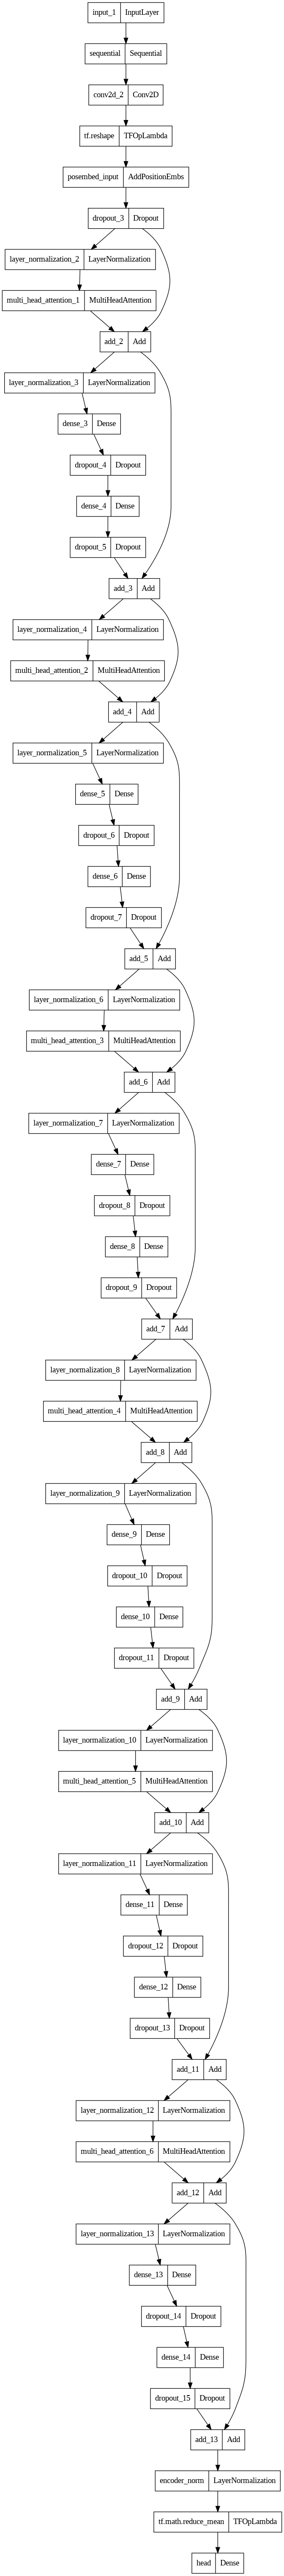

In [13]:
tf.keras.utils.plot_model(ViT_model, rankdir = 'TB')

In [14]:
### model 

ViT_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-3), 
                  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                  metrics=[tf.keras.metrics.CategoricalAccuracy(name = "accuracy"), tf.keras.metrics.TopKCategoricalAccuracy(k = 5, name = 'top5 acc')]) 
#tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")],) 
# from logits = True, because Dense layer has linear activation


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.8,
                              patience = 5, min_lr = 1e-5, verbose = 1)


ViT_Train = ViT_model.fit(train_ds, 
                        epochs = 120, 
                        validation_data = valid_ds, callbacks = [reduce_lr])

Epoch 1/120
313/313 [==============================] - 29s 72ms/step - loss: 2.0664 - accuracy: 0.2129 - top5 acc: 0.7324 - val_loss: 1.8836 - val_accuracy: 0.2936 - val_top5 acc: 0.8269 - lr: 0.0020
Epoch 2/120
313/313 [==============================] - 21s 68ms/step - loss: 1.8430 - accuracy: 0.3175 - top5 acc: 0.8364 - val_loss: 1.7655 - val_accuracy: 0.3382 - val_top5 acc: 0.8586 - lr: 0.0020
Epoch 3/120
313/313 [==============================] - 22s 69ms/step - loss: 1.7442 - accuracy: 0.3590 - top5 acc: 0.8615 - val_loss: 1.6731 - val_accuracy: 0.3813 - val_top5 acc: 0.8787 - lr: 0.0020
Epoch 4/120
313/313 [==============================] - 22s 70ms/step - loss: 1.6524 - accuracy: 0.3927 - top5 acc: 0.8837 - val_loss: 1.6103 - val_accuracy: 0.4042 - val_top5 acc: 0.8924 - lr: 0.0020
Epoch 5/120
313/313 [==============================] - 22s 69ms/step - loss: 1.5863 - accuracy: 0.4181 - top5 acc: 0.8953 - val_loss: 1.5402 - val_accuracy: 0.4390 - val_top5 acc: 0.9037 - lr: 0.0020


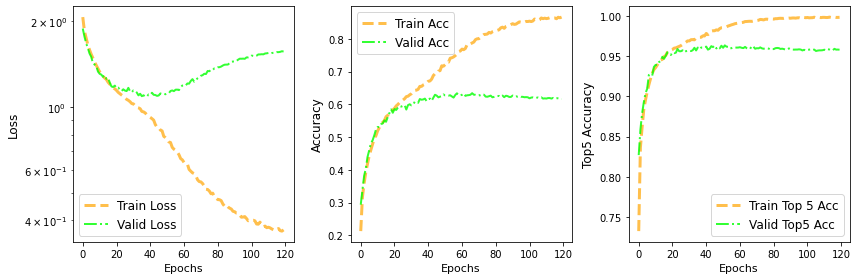

In [15]:
### Plot train and validation curves
loss = ViT_Train.history['loss']
v_loss = ViT_Train.history['val_loss']

acc = ViT_Train.history['accuracy'] 
v_acc = ViT_Train.history['val_accuracy']

top5_acc = ViT_Train.history['top5 acc']
val_top5_acc = ViT_Train.history['val_top5 acc']
epochs = range(len(loss))

fig = plt.figure(figsize = (12, 4))
plt.subplot(1, 3, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle = '--', linewidth = 3, color = 'orange', alpha = 0.7, label = 'Train Loss')
plt.plot(epochs, v_loss, linestyle = '-.', linewidth = 2, color = 'lime', alpha = 0.8, label = 'Valid Loss')
# plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize = 11)
plt.ylabel('Loss', fontsize = 12)
plt.legend(fontsize = 12)
plt.subplot(1, 3, 2)
plt.plot(epochs, acc, linestyle = '--', linewidth = 3, color = 'orange', alpha = 0.7, label = 'Train Acc')
plt.plot(epochs, v_acc, linestyle = '-.', linewidth = 2, color = 'lime', alpha = 0.8, label = 'Valid Acc') 
plt.xlabel('Epochs', fontsize = 11)
plt.ylabel('Accuracy', fontsize = 12)
plt.legend(fontsize = 12)
plt.subplot(1, 3, 3)
plt.plot(epochs, top5_acc, linestyle = '--', linewidth = 3, color = 'orange', alpha = 0.7, label = 'Train Top 5 Acc')
plt.plot(epochs, val_top5_acc, linestyle = '-.', linewidth = 2, color = 'lime', alpha = 0.8, label = 'Valid Top5 Acc') 
plt.xlabel('Epochs', fontsize = 11)
plt.ylabel('Top5 Accuracy', fontsize = 12)
plt.legend(fontsize = 12)
plt.tight_layout()
# plt.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/train_acc.png', dpi=250)
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def conf_matrix(predictions): 
    ''' Plots conf. matrix and classification report '''
    cm = confusion_matrix(y_test, np.argmax(np.round(predictions), axis = 1))
    print("Classification Report:\n")
    cr = classification_report(y_test,
                                np.argmax(np.round(predictions), axis = 1), 
                                target_names = [class_types[i] for i in range(len(class_types))])
    print(cr)
    plt.figure(figsize = (12,12))
    sns_hmp = sns.heatmap(cm, annot = True, xticklabels = [class_types[i] for i in range(len(class_types))], 
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt = "d")
    fig = sns_hmp.get_figure()
    # fig.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/heatmap.png', dpi=250)

313/313 [==============================] - 5s 12ms/step
Classification Report:

              precision    recall  f1-score   support

    airplane       0.61      0.68      0.64      1000
  automobile       0.72      0.71      0.71      1000
        bird       0.50      0.56      0.52      1000
         cat       0.44      0.51      0.47      1000
        deer       0.56      0.55      0.55      1000
         dog       0.49      0.52      0.51      1000
        frog       0.74      0.62      0.67      1000
       horse       0.68      0.62      0.65      1000
        ship       0.74      0.74      0.74      1000
       truck       0.70      0.61      0.65      1000

    accuracy                           0.61     10000
   macro avg       0.62      0.61      0.61     10000
weighted avg       0.62      0.61      0.61     10000



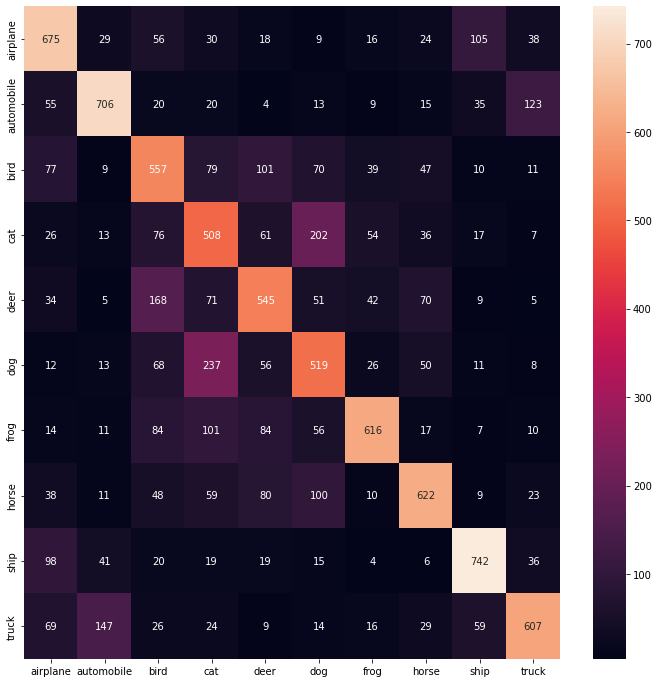

In [17]:
pred_class_resnet50 = ViT_model.predict(x_test)

conf_matrix(pred_class_resnet50)